# TikTok Google Play Review Analysis
## TikTok is one of the most popular social media apps today. It is famous for its short videos. TikTok will have 834.3 million monthly users worldwide in 2023, according to forecast from Insider Intelligence. It is now the third-largest of the Big Five worldwide social networks (Facebook, Instagram, TikTok, Snapchat, and Twitter).
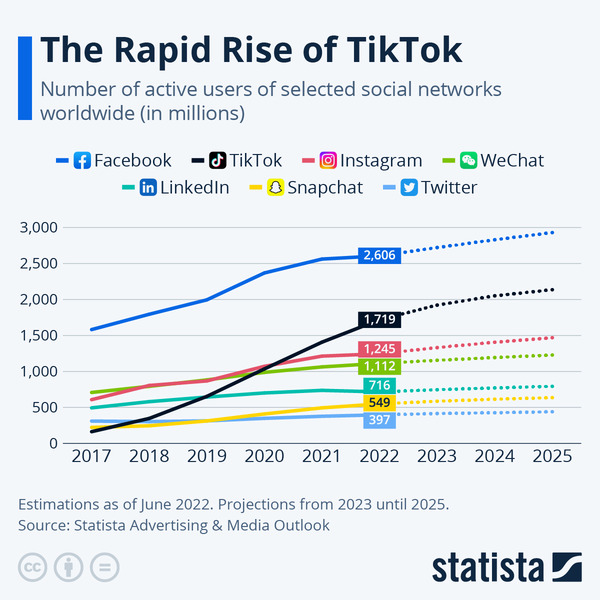
## People might have mixed feelings towards this app. This analysis uses data from Google Play Store to focuses on TikTok reviews and find out what people feel about the app.

# Dataset
## This dataset belongs to the TikTok app available on the Google Play Store. The Dataset mostly has user reviews and the various comments made by the users.


# Prepare the environment and import data

In [1]:
## Mount notebook to Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [7]:
import os
# set working directoty on google drive
root_dir = "/content/drive/My Drive/"
project_folder = "Data Analysis/TikTok Review Analysis"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Data Analysis/TikTok Review Analysis

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import string
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
data = pd.read_csv("tiktok_google_play_reviews.csv")

<ipython-input-17-758a10755fe6>:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("tiktok_google_play_reviews.csv")


# Data exploration

In [11]:
data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,68ccaec8-1415-4301-a85e-3004679a3a83,Cassie Moore,https://play-lh.googleusercontent.com/a/ALm5wu...,No words,5,0,27.1.3,2022-11-29 21:55:37,NaN,NaN
1,d84cbfd3-6aa3-485c-aaf9-c5dca27dc966,Kaleb Plummer,https://play-lh.googleusercontent.com/a-/ACNPE...,Great fun app so far!,5,0,NaN,2022-11-29 21:55:04,NaN,NaN
2,96618aa1-31e5-4259-8649-89b75d962f00,Rylee Maher,https://play-lh.googleusercontent.com/a/ALm5wu...,The app would get a higher rating but I litera...,1,0,27.1.3,2022-11-29 21:54:48,NaN,NaN
3,078c0bda-598b-474e-a04e-d7cb3e6f6301,Kittykatelyn Romilly,https://play-lh.googleusercontent.com/a-/ACNPE...,I WISH I COULD GIVE THIS A 100 PERCENT RATING ...,5,0,NaN,2022-11-29 21:54:35,NaN,NaN
4,8e68c5cd-b12a-4206-a8da-6bfdbff44ae3,Loveness Malenga,https://play-lh.googleusercontent.com/a-/ACNPE...,Pictures and record,5,0,NaN,2022-11-29 21:54:21,NaN,NaN


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460287 entries, 0 to 460286
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              460287 non-null  object
 1   userName              460287 non-null  object
 2   userImage             460287 non-null  object
 3   content               460271 non-null  object
 4   score                 460287 non-null  int64 
 5   thumbsUpCount         460287 non-null  int64 
 6   reviewCreatedVersion  333953 non-null  object
 7   at                    460287 non-null  object
 8   replyContent          260 non-null     object
 9   repliedAt             260 non-null     object
dtypes: int64(2), object(8)
memory usage: 35.1+ MB


In [13]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,460287.0,4.234919,1.430718,1.0,4.0,5.0,5.0,5.0
thumbsUpCount,460287.0,3.210601,183.506791,0.0,0.0,0.0,0.0,40311.0


# Data cleaining

In [21]:
# We only need content and score variables from the data
data2 = data[["content", "score"]]

In [23]:
# Check and drop null values
print(data2.isnull().sum())

content    16
score       0
dtype: int64


In [25]:
data2 = data2.dropna()
data2

,content,score
0,No words,5
1,Great fun app so far!,5
2,The app would get a higher rating but I litera...,1
3,I WISH I COULD GIVE THIS A 100 PERCENT RATING ...,5
4,Pictures and record,5
...,...,...
460282,😍😍,5
460283,Very nice,1
460284,Nice,5
460285,TikTok love your sad,5


In [29]:
# Prepare data for sentiment analysis
stopword=set(stopwords.words('english'))
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data2["content"] = data2["content"].apply(clean)

# Sentiment Analysis

In [28]:
# Distribution of ratings 
ratings = data2["score"].value_counts()
numbers = ratings.index
quantity = ratings.values
import plotly.express as px
figure = px.pie(data2, 
             values=quantity, 
             names=numbers,hole = 0.5)
figure.show()

In [30]:
# 74% of the users have given five ratings to TikTok, and 13% of the users have rated it with 1

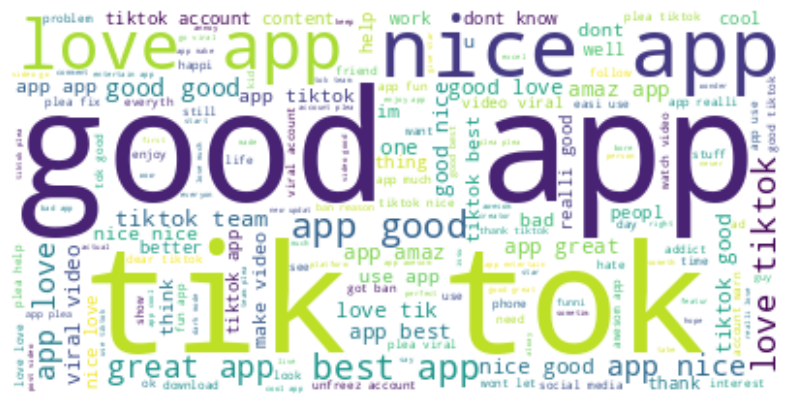

In [34]:
# wordcloud of reviews
text = " ".join(i for i in data2.content)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
# categorize the reviews into three groups: Positive, Negative, and Neutral by calculating the sentiment scores of the reviews
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
data2["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data2["content"]]
data2["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data2["content"]]
data2["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data2["content"]]
data3 = data2[["content", "Positive", "Negative", "Neutral"]]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
data3.head()

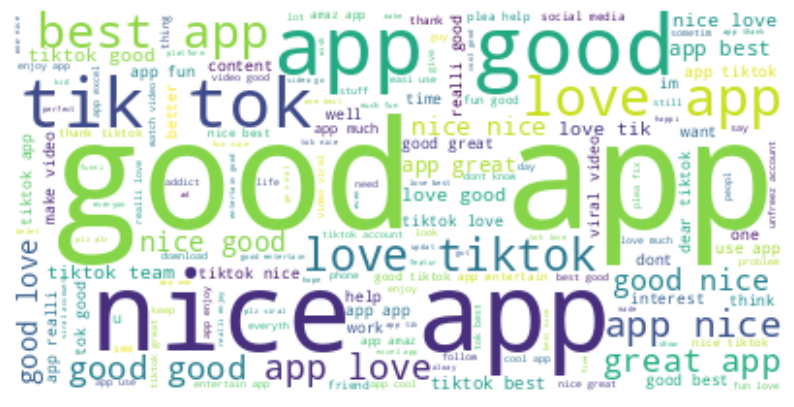

In [36]:
# create another wordcloud for the positive reviews
positive =' '.join([i for i in data3['content'][data3['Positive'] > data3["Negative"]]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive)
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

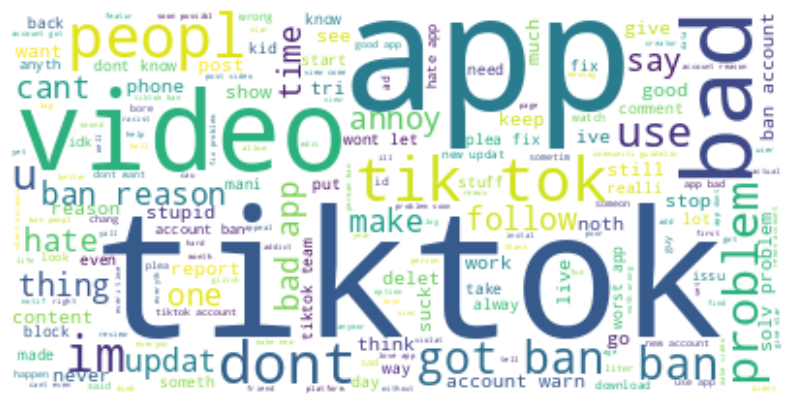

In [37]:
# create another wordcloud for the negative reviews
negative =' '.join([i for i in data3['content'][data3['Positive'] < data3["Negative"]]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(negative)
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Findings

## In Google Play Store, majority of reviewers have five-star ratings of Tiktok app and some reviewers don't like the app. The most used words in positive reviews are "good" "nice" "love" and "best", while words like "hate" "ban" and "stop" appear frequently in negative reviews. 